# Data Processing

In [ ]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Mount drive to import data file
from google.colab import drive
drive.mount('/content/drive')

# Ethan drive mount
# drive.mount('/content/gdrive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing data
# retrieved from https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download
import torchvision.transforms as transforms
import torchvision.datasets as d
from torch.utils.data import DataLoader, Dataset, Subset

# https://pytorch.org/vision/0.9/transforms.html
# https://pytorch.org/vision/main/generated/torchvision.tv_tensors.Image.html
# https://discuss.pytorch.org/t/resizing-dataset/75620/4

# transform images to rescale, resize, normalize
transform = transforms.Compose([
    transforms.Resize(256),  # Resize the shortest side to 256 pixels
    transforms.CenterCrop(224),  # Crop the center to 224x224 pixels
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet mean and std
])

# Load your dataset with the defined transformations
# my path is /content/drive/My Drive/Colab Notebooks/APS360/Data NvsBvsV & /content/drive/My Drive/Colab Notebooks/APS360/Data Augmentation
dataset = d.ImageFolder("/content/drive/My Drive/Colab Notebooks/APS360/Data NvsBvsV", transform=transform)
dataset_aug = d.ImageFolder("/content/drive/My Drive/Colab Notebooks/APS360/Data Augmentation", transform=transform)

In [ ]:
# pick X/X/X split
# Rebalanced dataset to 1440 images per class
torch.manual_seed(0)  # MISSING OTHER SEEDS

print(f'Total images: {len(dataset)}')
print("Classes")
print(dataset.class_to_idx)
# Split dataset
train, val, test = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
print(f'Training images: {len(train)}')
print(f'Validation images: {len(val)}')
print(f'Test images: {len(test)}')
print()
print("Data augmentation dataset")
print(f'Total images: {len(dataset_aug)}')
print("Classes")
print(dataset_aug.class_to_idx)
train_aug, val_aug, test_aug = torch.utils.data.random_split(dataset_aug, [0.8, 0.1, 0.1])
print(f'Training images: {len(train_aug)}')
print(f'Validation images: {len(val_aug)}')
print(f'Test images: {len(test_aug)}')

Total images: 4350
{'BACTERIA': 0, 'NORMAL': 1, 'VIRUS': 2}
Training images: 3480
Validation images: 435
Test images: 435
Data augmentation dataset
{'BACTERIAL': 0, 'NORMAL': 1, 'VIRUS': 2}
Total images: 1566
Training images: 1253
Validation images: 157
Test images: 156


In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        if isinstance(image, torch.Tensor):
          image = transforms.ToPILImage()(image)
        if self.transform:
            image = self.transform(image)
        return image, label

## Visualize Data

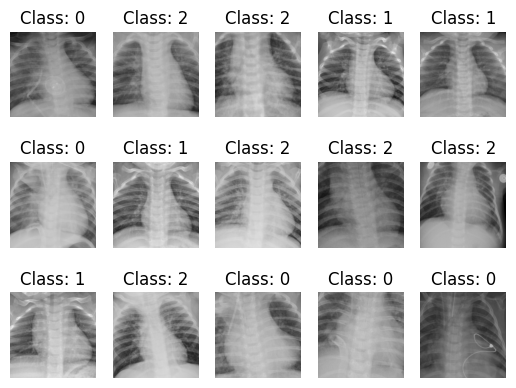

In [ ]:
# Function to denormalize and convert tensor to numpy array
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor (C, H, W) to Numpy (H, W, C)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # Denormalize
    img = np.clip(img, 0, 1)  # Clip to the valid range [0, 1]
    plt.imshow(img)
    # plt.show()

# Visualize the first 15 images
k = 0
for img, label in train:
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    imshow(img)
    plt.title(f'Class: {label}')  # Set the label as xlabel

    k += 1
    if k > 14:
        break
plt.show()

# Baseline Model

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

In [ ]:
#confirming class labels
print(np.unique(y_test))

[0 1 2]


To alter the SVM model to classify three classes instead of 2, we have the option of taking two approaches. The first is One-vs-One approach where a classifier is responsible for each possible pair of classes, while ignoring the others. During prediction, a majority vote is taken from each classifier to determine the output. The other approach is the One-vs-All approach where we train a single classifer for each class and compare it against all other classes (grouped as a whole, essentially a negative class). During prediction, each classifier outputs a likelihood score for their respective class and the highest score is selected. When the number of classes is smaller, OvO is more advantagoues, on the other hand OvR scales linearly and is better for larger class sizes. Since we only have 3 classes, we decided to go with the OvO approach.

In [ ]:
# https://scikit-learn.org/stable/modules/svm.html
#Sample data set
x_sample = x_train[:1000]
y_sample = y_train[:1000]


svm_model = SVC(kernel = 'linear', decision_function_shape='ovo')

svm_model.fit(x_sample, y_sample)

prediction = svm_model.predict(x_test)

# Output results
accuracy = svm_model.score(x_test, y_test)
print(f"Model accuracy {accuracy*100}\nModel error {(1-accuracy)*100}")

print(classification_report(y_test, prediction))

Model accuracy 67.4364896073903
Model error 32.56351039260969
              precision    recall  f1-score   support

           0       0.61      0.64      0.62       152
           1       0.87      0.82      0.84       139
           2       0.57      0.57      0.57       142

    accuracy                           0.67       433
   macro avg       0.68      0.68      0.68       433
weighted avg       0.68      0.67      0.68       433



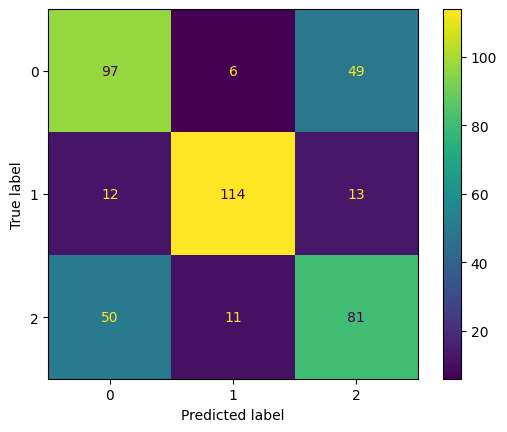

In [ ]:
cm = confusion_matrix(y_test, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()  # optional color map

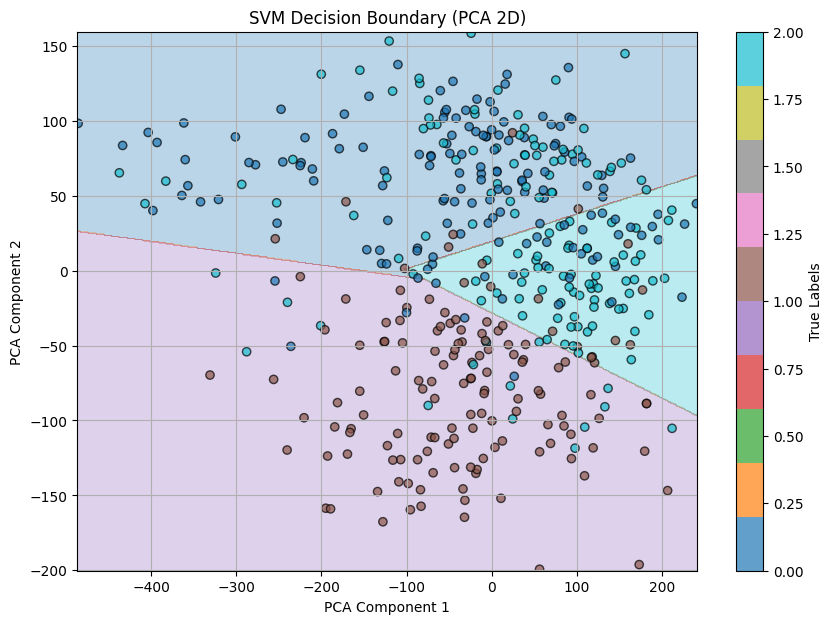

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

# Reduce both train and test sets to 2D
pca = PCA(n_components=2)
x_train_2d = pca.fit_transform(x_sample)
x_test_2d = pca.transform(x_test)

# Train new SVM on reduced data
svm_2d = SVC(kernel='linear', decision_function_shape='ovo')
svm_2d.fit(x_train_2d, y_sample)

# Create meshgrid
x_min, x_max = x_test_2d[:, 0].min() - 1, x_test_2d[:, 0].max() + 1
y_min, y_max = x_test_2d[:, 1].min() - 1, x_test_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

# Predict on meshgrid to get decision regions
Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='tab10')
scatter = plt.scatter(x_test_2d[:, 0], x_test_2d[:, 1], c=y_test, cmap='tab10', edgecolors='k', alpha=0.7)
plt.title("SVM Decision Boundary (PCA 2D)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, label='True Labels')
plt.grid(True)
plt.show()


In [ ]:
# Step 1: Apply PCA to Reduce for Visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(x_train)
support_vectors_pca = pca.transform(svm_model.support_vectors_)  # Only transform support vectors

# Step 2: Create a Smaller Grid for Decision Boundary
x_min, x_max = X_train_pca[:, 0].min(), X_train_pca[:, 0].max()
y_min, y_max = X_train_pca[:, 1].min(), X_train_pca[:, 1].max()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),  # Reduce grid size from 100x100 to 50x50
                     np.linspace(y_min, y_max, 50))

# Step 3: Predict Directly on PCA-Reduced Grid (No Inverse Transform)
grid_points_pca = np.c_[xx.ravel(), yy.ravel()]
Z = svm_model.predict(pca.inverse_transform(grid_points_pca))  # Predict without large inverse transformation
Z = Z.reshape(xx.shape)

# Step 4: Plot Decision Boundary
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')

classes = np.unique(y_train)
colors = ["blue", "red"]  # or however many classes you have

for cls, col in zip(classes, colors):
    plt.scatter(X_train_pca[y_train == cls, 0],
                X_train_pca[y_train == cls, 1],
                c=col,
                alpha=0.5,
                edgecolors='w',
                label=f"Train Data (Class {cls})")

plt.scatter(support_vectors_pca[:, 0], support_vectors_pca[:, 1], edgecolors='black', facecolors='none', s=100, label="Support Vectors")

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("SVM Decision Boundary")
plt.legend()
plt.show()


# Primary Model

## Helper Functions

In [ ]:
# model name function from lab 2 to help with data checkpoints and plotting
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

# evaluate function from lab 2
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        """ corr = outputs != labels
        total_err += int(corr.sum())"""
        total_loss += loss.item()
        total_epoch += len(labels)
        _, predicted = torch.max(outputs.data, 1)
        total_err += (predicted != labels).sum().item()
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

# from tut 3
def get_accuracy(model, train=False):
    if train:
        data = train
    else:
        data = val

    correct = 0
    total = 0
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

# train net function from lab 2
def train_net(net, batchsize, lr, epoch, train, val):
    criterion = nn.CrossEntropyLoss()
    optimizer=optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-5)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Convert data to tensors and load the batches
    traindataset = Dataset(train, transform=transform)
    valdataset = Dataset(val, transform=transform)
    trainloader = torch.utils.data.DataLoader(traindataset, batch_size=batchsize, shuffle=True)
    valloader = torch.utils.data.DataLoader(valdataset, batch_size=batchsize, shuffle=True)

    # Set up error and loss arrays
    train_error = np.zeros(epoch)
    train_loss = np.zeros(epoch)
    val_err = np.zeros(epoch)
    val_loss = np.zeros(epoch)

    # Initialize variables to track the best model
    best_val_err = float('inf')
    best_model_path = None

    # Iterate through and train the data
    for epoch_idx in range(epoch):
        total_train_samples = 0
        i = 0
        for image, label in trainloader:
            optimizer.zero_grad()
            output = net(image)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            train_loss[epoch_idx] += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_error[epoch_idx] += (predicted != label).sum().item()
            total_train_samples += len(label)
            i += 1

        # Calculate error and loss for each epoch
        train_loss[epoch_idx] /= (i + 1)
        train_error[epoch_idx] /= total_train_samples
        val_err[epoch_idx], val_loss[epoch_idx] = evaluate(net, valloader, criterion)
        print(f"Epoch {epoch_idx+1}: Train Loss: {train_loss[epoch_idx]}, Train Error: {train_error[epoch_idx]}, Val Loss: {val_loss[epoch_idx]}, Val Error: {val_err[epoch_idx]}")

        # Checkpoint after each epoch
        model_path = get_model_name(net.name, batchsize, lr, epoch_idx)
        torch.save(net.state_dict(), model_path)

        # Check if this epoch's validation error is the best so far
        if val_err[epoch_idx] < best_val_err:
            best_val_err = val_err[epoch_idx]
            best_model_path = f"best_model_{net.name}_bs{batchsize}_lr{lr}_epoch{epoch_idx}_val_err{best_val_err:.4f}.pt"
            torch.save(net.state_dict(), best_model_path)
            print(f"New best model saved at epoch {epoch_idx+1} with validation error: {best_val_err:.4f}")

    # Save the model metrics
    epochs = np.arange(1, epoch + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_error)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    print(f"Training completed. Best model saved at: {best_model_path}")
    return best_model_path  # Return the path to the best model

#From lab 2 to help plot curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Primary Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(FinalNet4, self).__init__()
        self.name = "Net"
        self.conv1 = nn.Conv2d(3, 5, 3)
        self.bn1 = nn.BatchNorm2d(5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 9, 3)
        self.bn2 = nn.BatchNorm2d(9)
        self.conv3 = nn.Conv2d(9, 12, 3)
        self.bn3 = nn.BatchNorm2d(12)
        self.fc1 = nn.Linear(12 * 26 * 26, 256)
        self.fc2 = nn.Linear(256, 3)
        self.dropout = nn.Dropout(0.6)

    def forward(self, x):
        x = self.pool(F.silu(self.bn1(self.conv1(x))))
        x = self.pool(F.silu(self.bn2(self.conv2(x))))
        x = self.pool(F.silu(self.bn3(self.conv3(x))))
        x = x.view(-1, 12 * 26 * 26)
        x = F.silu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# Check if the model can overfit
small_train = Subset(train, range(10))
small_val = Subset(val, range(10))

net=Net()
train_net(net, 12, 0.001, 20, small_train, small_val)

Epoch 1: Train Loss: 0.7644373178482056, Train Error: 0.9, Val Loss: 1.8825851678848267, Val Error: 0.8
New best model saved at epoch 1 with validation error: 0.8000
Epoch 2: Train Loss: 0.08618728816509247, Train Error: 0.1, Val Loss: 1.8552967309951782, Val Error: 0.7
New best model saved at epoch 2 with validation error: 0.7000
Epoch 3: Train Loss: 0.05909256264567375, Train Error: 0.0, Val Loss: 2.450502872467041, Val Error: 0.7
Epoch 4: Train Loss: 0.02982126735150814, Train Error: 0.0, Val Loss: 2.3175384998321533, Val Error: 0.7
Epoch 5: Train Loss: 0.028727877885103226, Train Error: 0.0, Val Loss: 2.4716687202453613, Val Error: 0.7
Epoch 6: Train Loss: 0.029963454231619835, Train Error: 0.0, Val Loss: 2.564466953277588, Val Error: 0.7
Epoch 7: Train Loss: 0.01806481182575226, Train Error: 0.0, Val Loss: 2.611815929412842, Val Error: 0.8
Epoch 8: Train Loss: 0.02095041051506996, Train Error: 0.0, Val Loss: 2.8199048042297363, Val Error: 0.8
Epoch 9: Train Loss: 0.022221293300390

'best_model_Net_bs12_lr0.001_epoch1_val_err0.7000.pt'

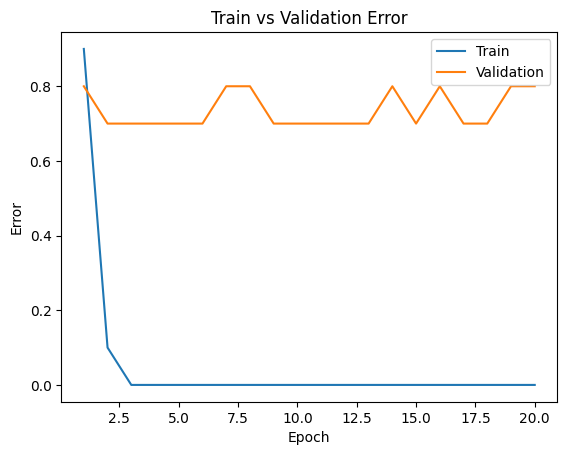

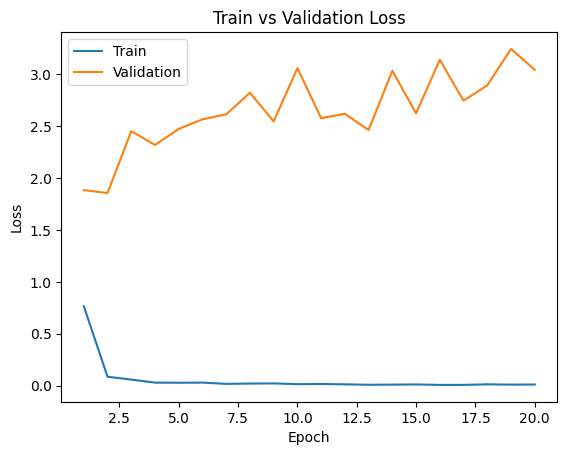

In [ ]:
# visualize training
model_path = get_model_name("Net", batch_size=12, learning_rate=0.001, epoch=19)
plot_training_curve(model_path)

# Hyperparameter Tuning
## Using GPU

In [ ]:
def train_net_gpu(net, batchsize, lr, epoch, train, val):
    # Set device to GPU if available, otherwise CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Move model to GPU
    net = net.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=5e-4)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Convert data to tensors and load the batches
    traindataset = Dataset(train, transform=transform)
    valdataset = Dataset(val, transform=transform)
    trainloader = torch.utils.data.DataLoader(traindataset, batch_size=batchsize, shuffle=True, num_workers=4, pin_memory=True)
    valloader = torch.utils.data.DataLoader(valdataset, batch_size=batchsize, shuffle=True, num_workers=4, pin_memory=True)

    # Set up error and loss arrays
    train_error = np.zeros(epoch)
    train_loss = np.zeros(epoch)
    val_err = np.zeros(epoch)
    val_loss = np.zeros(epoch)

    # Initialize variables to track the best model
    best_val_err = float('inf')
    best_model_path = None

    # Iterate through and train the data
    for epoch_idx in range(epoch):
        net.train()  # Set model to training mode
        total_train_samples = 0
        i = 0
        for image, label in trainloader:
            # Move data to GPU
            image, label = image.to(device), label.to(device)
            optimizer.zero_grad()
            output = net(image)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            train_loss[epoch_idx] += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_error[epoch_idx] += (predicted != label).sum().item()
            total_train_samples += len(label)
            i += 1

        # Calculate error and loss for each epoch
        train_loss[epoch_idx] /= (i + 1)
        train_error[epoch_idx] /= total_train_samples

        # Evaluate on validation set
        net.eval()  # Set model to evaluation mode
        val_err[epoch_idx], val_loss[epoch_idx] = evaluate(net, valloader, criterion, device)
        print(f"Epoch {epoch_idx+1}: Train Loss: {train_loss[epoch_idx]}, Train Error: {train_error[epoch_idx]}, Val Loss: {val_loss[epoch_idx]}, Val Error: {val_err[epoch_idx]}")

        # Checkpoint after each epoch
        model_path = get_model_name(net.name, batchsize, lr, epoch_idx)
        torch.save(net.state_dict(), model_path)

        # Check if this epoch's validation error is the best so far
        if val_err[epoch_idx] < best_val_err:
            best_val_err = val_err[epoch_idx]
            best_model_path = f"best_model_{net.name}_bs{batchsize}_lr{lr}_epoch{epoch_idx}_val_err{best_val_err:.4f}.pt"
            torch.save(net.state_dict(), best_model_path)
            print(f"New best model saved at epoch {epoch_idx+1} with validation error: {best_val_err:.4f}")

    # Save the model metrics
    epochs = np.arange(1, epoch + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_error)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

    print(f"Training completed. Best model saved at: {best_model_path}")
    return best_model_path

# Update evaluate function for GPU (assuming it’s defined elsewhere)
def evaluate_gpu(net, loader, criterion, device):
    net.eval()
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)  # Move to GPU
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_err += (predicted != labels).sum().item()
            total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

# Testing

In [ ]:
def evaluate_net(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        """ corr = outputs != labels
        total_err += int(corr.sum())"""
        total_loss += loss.item()
        total_epoch += len(labels)
        _, predicted = torch.max(outputs.data, 1)
        total_err += (predicted != labels).sum().item()
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

In [ ]:
testloader = DataLoader(test, batch_size=32, shuffle=True)

In [ ]:
err_final , loss_final = evaluate_net(final4, testloader, nn.CrossEntropyLoss())


In [ ]:
print(f"Final error is {err_final}")

Final error is 0.6027713625866051


In [ ]:
from sklearn.metrics import confusion_matrix

def evaluate_net(net, loader, criterion, num_classes):
    """Evaluate the network on the validation/test set and compute the confusion matrix.

    Args:
        net: PyTorch neural network object
        loader: PyTorch data loader for the validation/test set
        criterion: The loss function
        num_classes: Number of classes in the dataset

    Returns:
        err: A scalar for the avg classification error over the validation/test set
        loss: A scalar for the average loss function over the validation/test set
        conf_matrix: Confusion matrix as a NumPy array
    """
    net.eval()
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for i, data in enumerate(loader, 0):
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            total_epoch += len(labels)

            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            total_err += (predicted != labels).sum().item()

            # Store predictions and labels for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions, labels=np.arange(num_classes))

    # Compute error and loss
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)

    return err, loss, conf_matrix

In [ ]:
# Assuming you have a test loader, criterion, and trained model
num_classes = 3  # Replace with the actual number of classes in your dataset
err_final, loss_final, conf_matrix = evaluate_net(final4, testloader, nn.CrossEntropyLoss(), num_classes)

print(f"Error: {err_final}")
print(f"Loss: {loss_final}")
print("Confusion Matrix:")
print(conf_matrix)

Error: 0.6027713625866051
Loss: 2.8220738087381636
Confusion Matrix:
[[ 84   6  50]
 [ 72  53  17]
 [100  16  35]]


In [ ]:
print(f"Confusion Matrix:\n{conf_matrix}")

Confusion Matrix:
[[ 84   6  50]
 [ 72  53  17]
 [100  16  35]]


<Axes: >

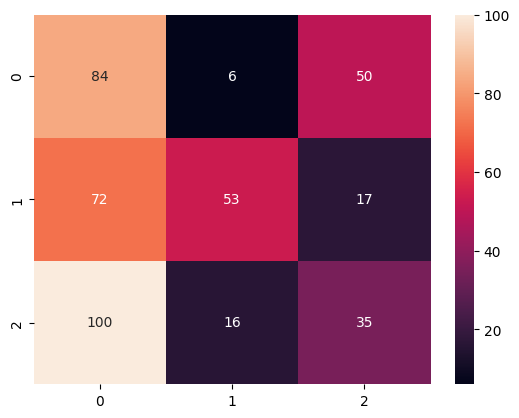

In [ ]:
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='g')